In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
from wordcloud import WordCloud
from dython.nominal import identify_nominal_columns, associations

In [148]:
# Carregando o Dataset
df = pd.read_pickle('../storage/pickle/dataframe_amostra_no_dummies0.15.pkl')
df = df.drop_duplicates()
# Tratando dado de idade
df["idade"] = pd.to_numeric(df["idade"])

df

,idade,sexo,patologia,severidade,evidencia_inicial,"are_the_symptoms_or_pain_increased_with_coughing,_with_an_effort_like_lifting_a_weight_or_from_forcing_a_bowel_movement",are_there_any_members_of_your_family_who_have_been_diagnosed_myasthenia_gravis,are_there_members_of_your_family_who_have_been_diagnosed_with_pancreatic_cancer,are_you_a_former_smoker,are_you_being_treated_for_osteoporosis,...,is_the_lesion_(or_are_the_lesions)_larger_than_1cm,is_the_rash_swollen,"is_your_bmi_less_than_185,_or_are_you_underweight",is_your_nose_or_the_back_of_your_throat_itchy,is_your_skin_much_paler_than_usual,were_you_born_prematurely_or_did_you_suffer_any_complication_at_birth,were_you_diagnosed_with_endocrine_disease_or_a_hormone_dysfunction,what_color_is_the_rash,where_is_the_affected_region_located,where_is_the_swelling_located
0,38,M,localized edema,4,oedeme,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,ankle(L)
1,35,M,urti,5,msk_dlr,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23,F,acute otitis media,4,douleurxx,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,48,F,panic attack,5,douleurxx,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,66,M,pulmonary neoplasm,3,dyspn,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194058,78,M,bronchiectasis,3,dyspn,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194059,72,F,panic attack,5,psy_depers,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194060,60,M,viral pharyngitis,4,rhino_clair,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194061,35,F,urti,5,douleurxx,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
# Conecta ao banco de dados
conn = psycopg2.connect(
    host="localhost",
    database="previsao-patologias",
    user="postgres",
    password="test"
)

cursor = conn.cursor()
query = "SELECT texto FROM tb_questoes WHERE tipo_resposta = 'binaria';"
cursor.execute(query)

# Pega resultado da query e transforma em lista para realizar iteração
tuplas_resultados = cursor.fetchall()
questoes = [item for tupla in tuplas_resultados for item in tupla]

In [150]:
questoes_binarias = []
for c in questoes:
    nome_coluna_tratado = c.replace(" ", "_").replace(".", "").replace("?", "").lower()
    questoes_binarias.append(nome_coluna_tratado)
    
colunas_dummies = [col for col in df.columns if col not in ['idade', 'patologia', 'severidade'] + questoes_binarias]

df_dummies = pd.get_dummies(df, columns=colunas_dummies, dtype=int)

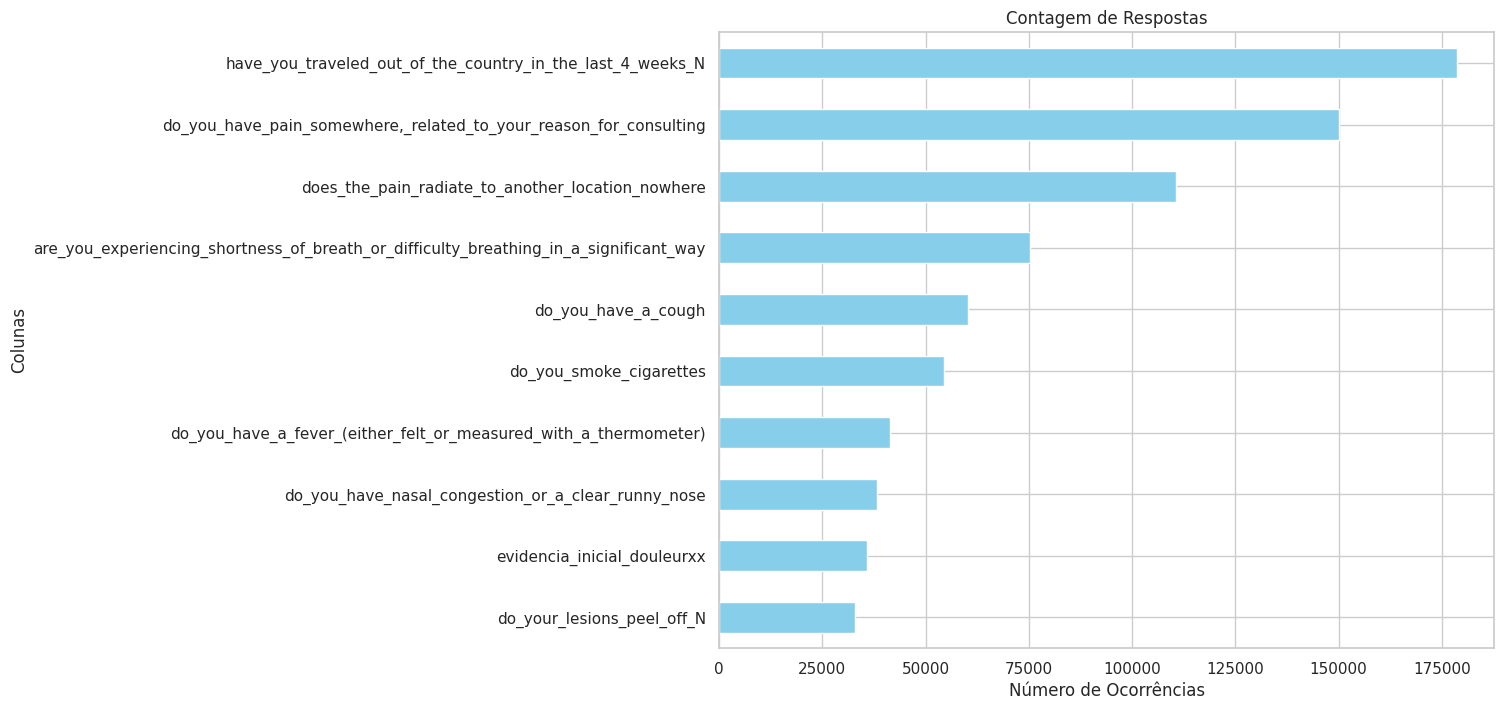

In [151]:
# Encontrando a coluna que não está na lista especificada
ficha_clinica = [coluna for coluna in df_dummies.columns if coluna not in ["idade", "sexo_M", "sexo_F", "patologia", "severidade", "evidencia_inicial"]]

# Conta a ocorrência de "1" em cada coluna
ocorrencias = df_dummies[ficha_clinica].astype(int).sum(axis=0)

# Filtra as colunas que acabam com "_0" - São colunas que representam perguntas multiescolhas que não foram respondidas
colunas_sem_zero = [coluna for coluna in ficha_clinica if not coluna.endswith("_0")]

# Conta a ocorrência de "1" em cada coluna
ocorrencias = df_dummies[colunas_sem_zero].astype(int).sum(axis=0)

# Ordena as colunas pelo número de ocorrências de "1"
ocorrencias = ocorrencias.sort_values(ascending=True)

plt.figure(figsize=(10, 8))
ocorrencias.nlargest(10)[::-1].plot(kind='barh', color='skyblue')
plt.title('Contagem de Respostas')
plt.xlabel('Número de Ocorrências')
plt.ylabel('Colunas')
plt.show()

In [152]:
# Encontrando a coluna que não está na lista especificada
ficha_clinica = [coluna for coluna in df_dummies.columns if coluna not in ["idade", "sexo_M", "sexo_F", "patologia", "severidade", "evidencia_inicial"]]

# Filtra as colunas que acabam com "_0" - São colunas que representam perguntas multiescolhas que não foram respondidas
colunas_sem_zero = [coluna for coluna in ficha_clinica if not coluna.endswith("_0")]

# Conta a ocorrência de "1" em cada coluna
ocorrencias = df_dummies[colunas_sem_zero].astype(int).sum(axis=0)

# Ordena as colunas pelo número de ocorrências de "1"
ocorrencias = ocorrencias.sort_values(ascending=True)

# Criar DataFrame
df_ocorrencias = pd.DataFrame({
    'Coluna': ocorrencias.index,
    'Ocorrências': ocorrencias.values
})

# Exibir o DataFrame como tabela
df_ocorrencias[::-1].head(10)

,Coluna,Ocorrências
586,have_you_traveled_out_of_the_country_in_the_la...,178723
585,"do_you_have_pain_somewhere,_related_to_your_re...",150180
584,does_the_pain_radiate_to_another_location_nowhere,110734
583,are_you_experiencing_shortness_of_breath_or_di...,75348
582,do_you_have_a_cough,60204
581,do_you_smoke_cigarettes,54542
580,do_you_have_a_fever_(either_felt_or_measured_w...,41276
579,do_you_have_nasal_congestion_or_a_clear_runny_...,38221
578,evidencia_inicial_douleurxx,35871
577,do_your_lesions_peel_off_N,32938


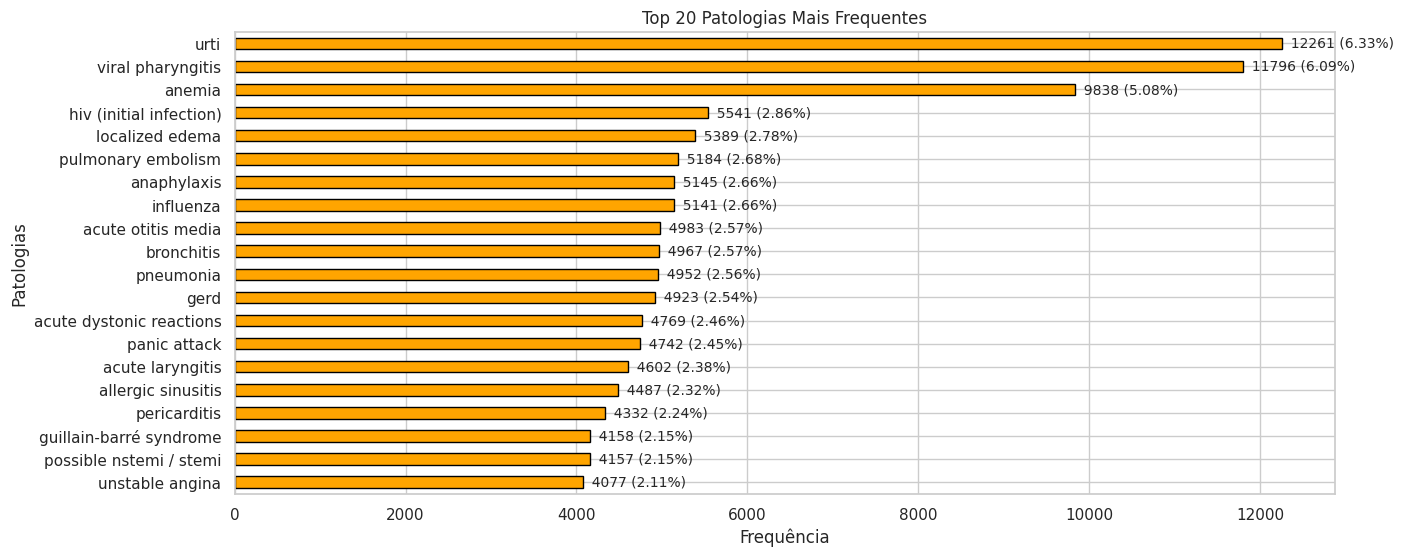

In [153]:
# Agrupar por patologia e contar as ocorrências
contagem_total_por_patologia = df['patologia'].value_counts().sort_values(ascending=False)

# Selecionar as 10 patologias mais frequentes
contagem_top10 = contagem_total_por_patologia.head(20)[::-1]

# Filtrar o DataFrame para incluir apenas as 10 patologias mais frequentes
df_top10 = df[df['patologia'].isin(contagem_top10.index)]

# Calcular as porcentagens
porcentagens = (contagem_top10 / len(df) * 100).round(2)

# Criar gráfico de barras horizontais com linha preta em volta de cada barra
fig, ax = plt.subplots(figsize=(8, 6))
barras = contagem_top10.plot(kind='barh', color='orange', edgecolor='black', ax=ax)

# Adicionar rótulos e título
ax.set_ylabel('Patologias')
ax.set_xlabel('Frequência')
ax.set_title('Top 20 Patologias Mais Frequentes')

# Ajustar o tamanho da fonte dos rótulos dos eixos
ax.tick_params(axis='both')

# Adicionar contagens e porcentagens nas barras
for barra, contagem, porcentagem in zip(barras.patches, contagem_top10, porcentagens):
    largura = barra.get_width()
    ax.text(largura + 1, barra.get_y() + barra.get_height() / 2, f'  {contagem} ({porcentagem}%)', va='center', fontsize=10)

# Exibir o gráfico
plt.subplots_adjust(right=1.5)
plt.show()

Text(0, 0.5, 'População por Categoria')

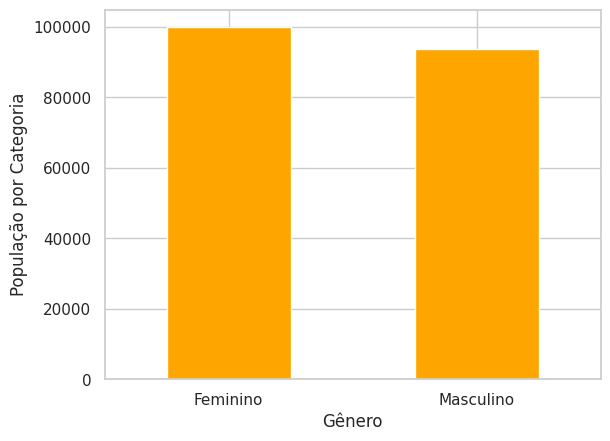

In [154]:
contagem_genero = df['sexo'].value_counts()
plot_genero = contagem_genero.plot(kind='bar', rot=0, color="orange")
plot_genero.set_xlabel("Gênero")
plot_genero.set_xticklabels(('Feminino', 'Masculino'))
plot_genero.set_ylabel('População por Categoria')

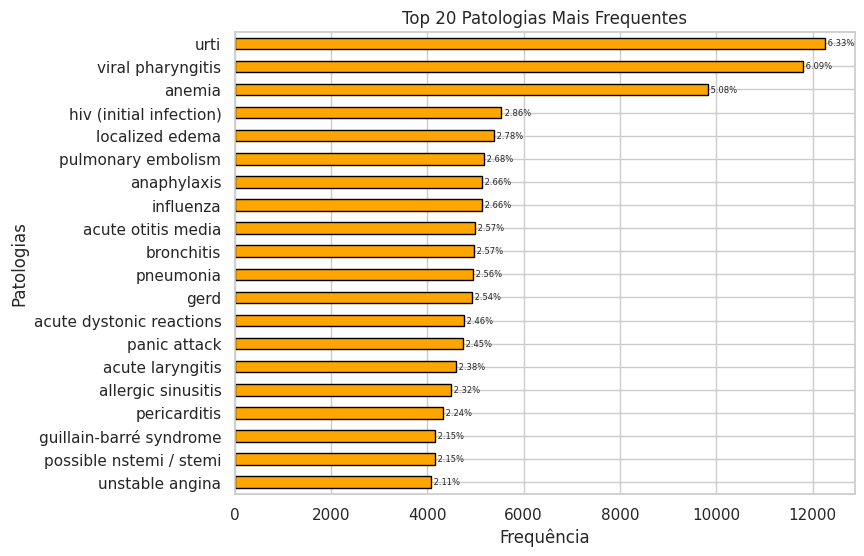

In [155]:
# Supondo que 'df' é o seu DataFrame original

# Agrupar por patologia e contar as ocorrências
contagem_total_por_patologia = df['patologia'].value_counts().sort_values(ascending=False)

# Selecionar as 10 patologias mais frequentes
contagem_top10 = contagem_total_por_patologia.head(20)[::-1]

# Filtrar o DataFrame para incluir apenas as 10 patologias mais frequentes
df_top10 = df[df['patologia'].isin(contagem_top10.index)]

# Calcular as porcentagens
porcentagens = (contagem_top10 / len(df) * 100).round(2)

# Criar gráfico de barras horizontais com linha preta em volta de cada barra
fig, ax = plt.subplots(figsize=(8, 6))
barras = contagem_top10.plot(kind='barh', color='orange', edgecolor='black', ax=ax)

# Adicionar rótulos e título
ax.set_ylabel('Patologias')
ax.set_xlabel('Frequência')
ax.set_title('Top 20 Patologias Mais Frequentes')

# Ajustar o tamanho da fonte dos rótulos dos eixos
ax.tick_params(axis='both')

# Adicionar porcentagens nas barras
for barra, porcentagem in zip(barras.patches, porcentagens):
    largura = barra.get_width()
    ax.text(largura + 1, barra.get_y() + barra.get_height() / 2, f' {porcentagem}%', va='center', fontsize=6)

# Exibir o gráfico
plt.show()

/tmp/ipykernel_15692/538782041.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['faixa_idade', 'severidade']).size().reset_index(name='contagem')


<Axes: xlabel='faixa_idade'>

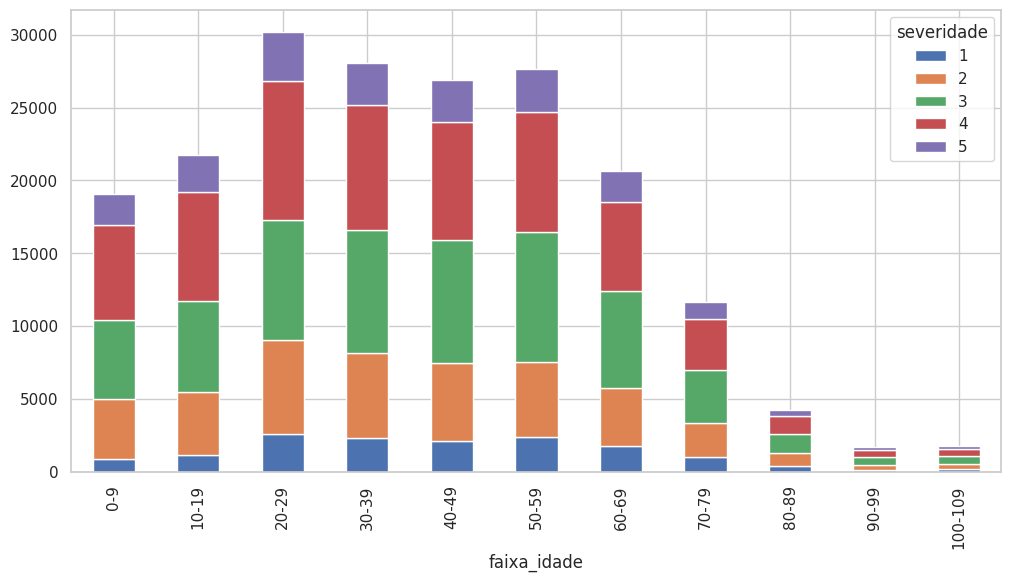

In [156]:
bins = range(0, df['idade'].max() + 10, 10)
labels = [f'{i}-{i+9}' for i in range(0, df['idade'].max(), 10)]
df['faixa_idade'] = pd.cut(df['idade'], bins=bins, labels=labels, right=False)
grouped_data = df.groupby(['faixa_idade', 'severidade']).size().reset_index(name='contagem')
pivot_table = grouped_data.pivot(index='faixa_idade', columns='severidade', values='contagem').fillna(0)
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))

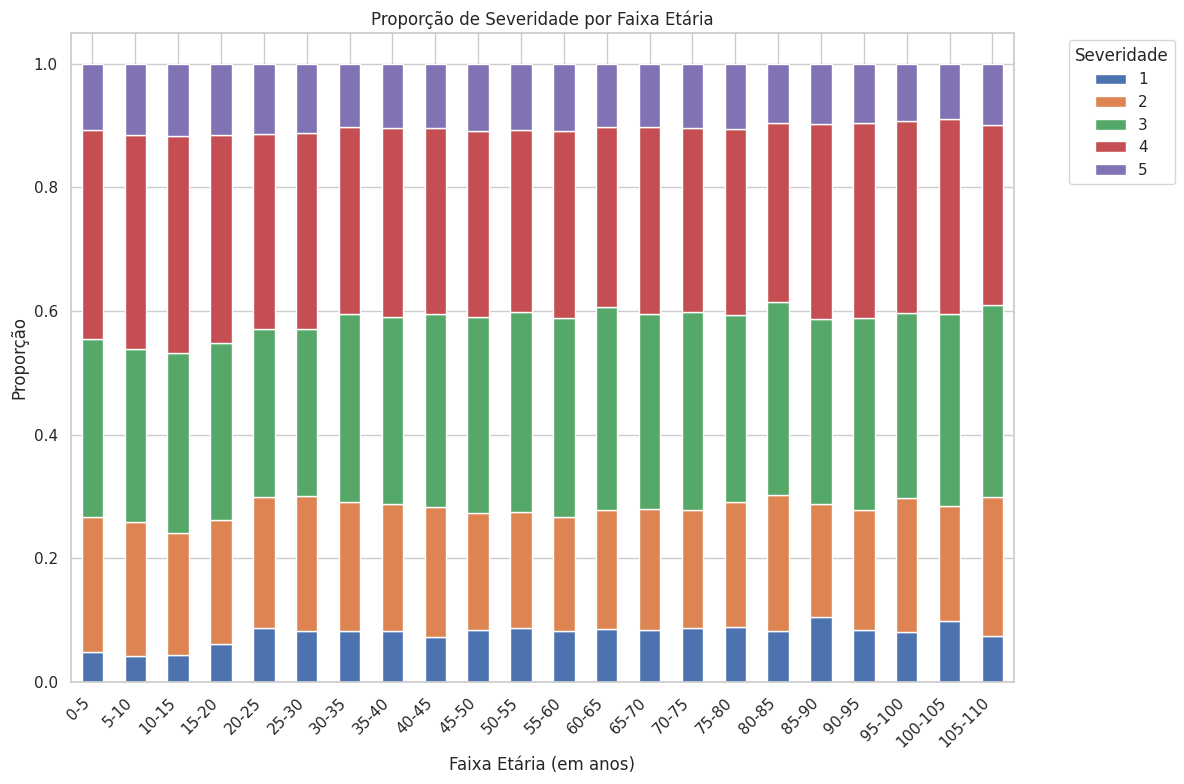

In [157]:
# Criar faixas de idade (de 5 em 5 anos)
bins = range(0, df['idade'].max() + 5, 5)

# Calcular a proporção de severidade para cada faixa etária
age_severity_counts = pd.crosstab(pd.cut(df['idade'], bins=bins, right=False), df['severidade'])
age_severity_proportions = age_severity_counts.div(age_severity_counts.sum(axis=1), axis=0)

# Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(12, 8))
ax = age_severity_proportions.plot(kind='bar', stacked=True, ax=ax)

# Adicionar rótulos e título
plt.xlabel('Faixa Etária (em anos)')
plt.ylabel('Proporção')
plt.title('Proporção de Severidade por Faixa Etária')

# Criar rótulos personalizados para cada barra
faixas_etarias_rotulos = [f'{int(left)}-{int(right)}' for left, right in zip(bins[:-1], bins[1:])]
ax.set_xticklabels(faixas_etarias_rotulos, rotation=45, ha="right")

plt.legend(title='Severidade', bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibir o gráfico
plt.tight_layout()
plt.show()

Tabela de evidências iniciais com severidade 1 original

In [158]:
# Filtrando os dados para observações com severidade 1
df_severity_1 = df[df['severidade'] == '1']

# Contando as ocorrências de cada evidência inicial
evidence_counts = df_severity_1['evidencia_inicial'].value_counts().reset_index()
evidence_counts.columns = ['evidencia_inicial', 'quantidade']

total_registros = len(df_severity_1)

evidence_counts['porcentagem'] = (evidence_counts['quantidade'] / total_registros) * 100
linha_total = pd.DataFrame({'quantidade': evidence_counts['quantidade'].sum(), 'porcentagem': 100 }, index=['Total']).map("{:.2f}%".format)
tabela_frequencia = pd.concat([evidence_counts, linha_total])

# Exibir a tabela
pd.concat([tabela_frequencia.head(18), tabela_frequencia.tail(1)])

,evidencia_inicial,quantidade,porcentagem
0,douleurxx,2418,16.354413
1,stridor,2077,14.048022
2,dyspn,1511,10.219817
3,oedeme,1260,8.522151
4,nausee,948,6.411904
5,diaph,899,6.080487
6,lesions_peau,678,4.585729
7,perte_appet,648,4.38282
8,fatig_mod,511,3.456206
9,contact_allergie,509,3.442678


Tabela de evidências iniciais com severidade 1 traduzida

In [159]:
data = [
    ['Dor localizada', '2418'],
    ['Som agudo ao respirar', '2077'],
    ['Falta de ar', '1511'],
    ['Inchaço', '1260'],
    ['Náusea', '948'],
    ['Suor demasiado', '899'],
    ['Vermelhidão na pele', '678'],
    ['Falta de apetite', '648'],
    ['Fadiga', '511'],
    ['Alergia recente', '509'],
    ['Sintomas pioram com esforço', '470'],
    ['Asfixia noturna', '436'],
    ['Piora ao deitar', '427'],
    ['Sensação de desmaio iminente', '395'],
    ['Chiado ao expirar', '382'],
    ['Diarréia', '382'],
    ['Dores musculares', '375'],
    ['Perda de consciência', '371'],
]

df_wordcloud_evidencias_iniciais_severidade_1 = pd.DataFrame(data, columns=['evidencia_inicial', 'quantidade'])
df_wordcloud_evidencias_iniciais_severidade_1

,evidencia_inicial,quantidade
0,Dor localizada,2418
1,Som agudo ao respirar,2077
2,Falta de ar,1511
3,Inchaço,1260
4,Náusea,948
5,Suor demasiado,899
6,Vermelhidão na pele,678
7,Falta de apetite,648
8,Fadiga,511
9,Alergia recente,509


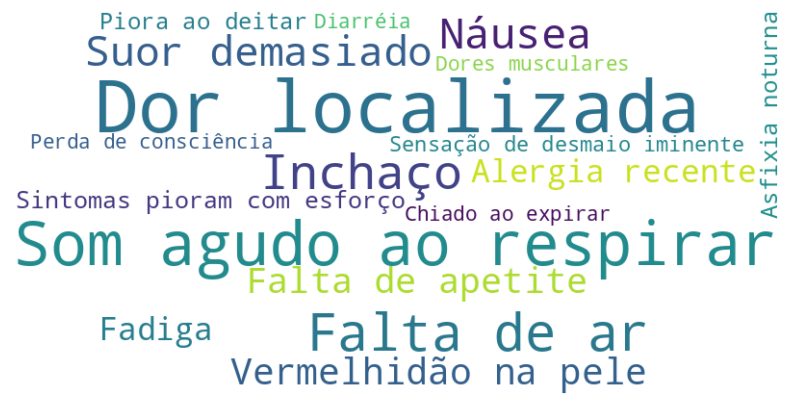

In [160]:
df_wordcloud_evidencias_iniciais_severidade_1 = pd.DataFrame(data, columns=['evidencia_inicial', 'quantidade'])

# Transforme a coluna 'quantidade' para tipo numérico
df_wordcloud_evidencias_iniciais_severidade_1['quantidade'] = pd.to_numeric(df_wordcloud_evidencias_iniciais_severidade_1['quantidade'])

# Crie a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(df_wordcloud_evidencias_iniciais_severidade_1['evidencia_inicial'], df_wordcloud_evidencias_iniciais_severidade_1['quantidade'])))

# Mostre a nuvem de palavras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/tmp/ipykernel_15692/154407524.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df.groupby(['patologia', 'Faixa Etária'])['idade'].median().reset_index()
/tmp/ipykernel_15692/154407524.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_patologias_por_faixa_etaria = summary_stats.groupby('Faixa Etária').apply(lambda x: x.nlargest(5, 'idade'))


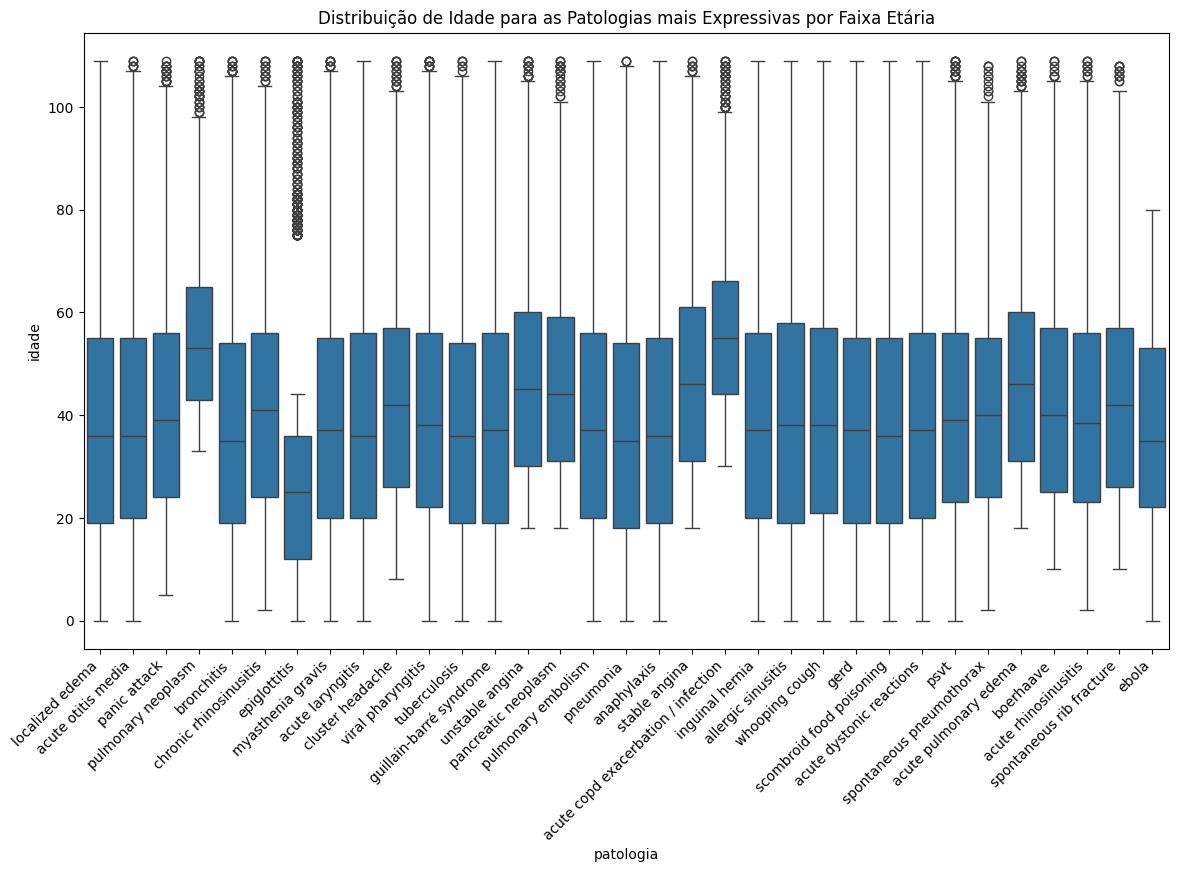

In [73]:
# Criar faixas de idade (de 5 em 5 anos)
bins = range(0, df['idade'].max() + 5, 5)

# Adicionar uma coluna 'Faixa Etária' ao DataFrame
df['Faixa Etária'] = pd.cut(df['idade'], bins=bins, right=False)

# Calcular estatísticas resumidas (mediana) para cada patologia em cada faixa etária
summary_stats = df.groupby(['patologia', 'Faixa Etária'])['idade'].median().reset_index()

# Selecionar as patologias mais expressivas para uma faixa etária (por exemplo, as top 5)
top_patologias_por_faixa_etaria = summary_stats.groupby('Faixa Etária').apply(lambda x: x.nlargest(5, 'idade'))

# Criar um gráfico de caixa apenas para as patologias mais expressivas
plt.figure(figsize=(14, 8))
sns.boxplot(x='patologia', y='idade', data=df[df['patologia'].isin(top_patologias_por_faixa_etaria['patologia'])])
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Idade para as Patologias mais Expressivas por Faixa Etária')
plt.show()

In [146]:
# Criar faixas de idade (de 5 em 5 anos)
bins = range(0, df['idade'].max() + 10, 10)

# Adicionar uma coluna 'Faixa Etária' ao DataFrame
df['Faixa Etária'] = pd.cut(df['idade'], bins=bins, right=False)

# Calcular estatísticas resumidas (mediana) para cada patologia em cada faixa etária
summary_stats = df.groupby(['severidade', 'Faixa Etária'])['idade'].median().reset_index()

# Selecionar as patologias mais expressivas para uma faixa etária (por exemplo, as top 5)
top_patologias_por_faixa_etaria = summary_stats.groupby('Faixa Etária').apply(lambda x: x.nlargest(5, 'idade'))

# Criar um gráfico de caixa apenas para as patologias mais expressivas
plt.figure(figsize=(14, 8))
sns.boxplot(x='severidade', y='idade', data=df[df['severidade'].isin(top_patologias_por_faixa_etaria['severidade'])])
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Idade para as Severidades mais Expressivas por Faixa Etária')
plt.show()

NameError: name 'df_boxplot' is not defined

In [67]:
# Selecionar as colunas relevantes
df_analise = df[['evidencia_inicial', 'severidade']]

# Calcular a tabela de frequência das evidências iniciais
tabela_frequencia = df_analise['evidencia_inicial'].value_counts().reset_index()
tabela_frequencia.columns = ['evidencia_inicial', 'quantidade']

# Calcular a porcentagem
total_registros = len(df_analise)
tabela_frequencia['porcentagem'] = (tabela_frequencia['quantidade'] / total_registros) * 100
linha_total = pd.DataFrame({'quantidade': tabela_frequencia['quantidade'].sum(), 'porcentagem': 100 }, index=['Total']).map("{:.2f}%".format)
tabela_frequencia = pd.concat([tabela_frequencia, linha_total])

# Exibir a tabela
pd.concat([tabela_frequencia.head(10), tabela_frequencia.tail(1)])

,evidencia_inicial,quantidade,porcentagem
0,douleurxx,35871,18.528505
1,dyspn,16354,8.447358
2,toux,14171,7.319769
3,rhino_clair,9146,4.724198
4,fievre,8022,4.143616
5,lesions_peau,5018,2.591956
6,crach_sg,4602,2.377078
7,oedeme,4398,2.271706
8,diaph,3940,2.035134
9,expecto,3863,1.995362


In [15]:
porcentagem_por_severidade = pd.crosstab(index=df['severidade'], columns='quantidade').sort_index(ascending=False)
porcentagem_por_severidade['porcentagem'] = (porcentagem_por_severidade['quantidade'] / porcentagem_por_severidade['quantidade'].sum() * 100).map("{:.2f}%".format)
linha_total = pd.DataFrame({'quantidade': porcentagem_por_severidade['quantidade'].sum(), 'porcentagem': 100 }, index=['Total']).map("{:.2f}%".format)
porcentagem_por_severidade = pd.concat([porcentagem_por_severidade, linha_total])
porcentagem_por_severidade.index.name = 'severidade'
porcentagem_por_severidade

,quantidade,porcentagem
severidade,,
5,20898,10.79%
4,60313,31.15%
3,58381,30.16%
2,39222,20.26%
1,14785,7.64%
Total,193599.00%,100.00%


In [95]:
patologias_severidade_1 = df[df['severidade'] == '1']
tabela_patologias_severidade_1 = patologias_severidade_1[['patologia']].groupby(['patologia']).size().reset_index(name='quantidade').sort_values(by='quantidade', ascending=False)
tabela_patologias_severidade_1['porcentagem'] = ((tabela_patologias_severidade_1['quantidade'] / len(df)) * 100).map("{:.2f}%".format)
tabela_patologias_severidade_1

,patologia,quantidade,porcentagem
1,anaphylaxis,5145,2.66%
4,possible nstemi / stemi,4157,2.15%
0,acute pulmonary edema,3646,1.88%
3,larygospasm,1707,0.88%
2,ebola,130,0.07%
